**Environment:**
- Linux 16.04
- CPU Intel i7, 8 Core(multithresholding is used here)
- Memory 16 GB
- Python 3.6

# Review Opinion Ectraction
This is a tutorial of my recent semantic clustering work. The purpose is to extract opinion phrases from the reviews and make clustering to find the most typical opinions. THe product reviews data are from amazon.com. The schema of is like the below:

1. Data clean and preprossing, especially filtering with opinion lexicon
2. Extract opinions based on Part of Speech(POS) rules
2. Apply Word Mover's distance based on Glove and Word2vec, and cluster them 
3. Finally we will compare the revelence accuracy of two method


**After importing packages, you can skip the parts 1, 2 since they are very time consuming**

### 1. Data Collection and Processing
#### 1.1 Data Collection and Description
- We scrapied a lot of reviews data from amazon.com, all of them are from nine products on this popular ecommerce platform.
- From porduct 0 - 8, for each of them, there are more than 190 rows of records and the total number is 14350 of rows.
- The original data contains multiple columns of ['name', 'profile', 'review_text', 'review_title', 'help_count', 'time_stamp', 'review_score', 'verified', 'product_name', 'product_link'].

#### 1.2 Data preprocessing
- We remove the stopping words, examples shown below:

### 2. Extract opinion 
- In this and the following parts, we use reviews text only. 
- For each review, we tag the POS(par of speech) for every words and extract opinions/phrases based on POS reguar expression. We designed 45 combination rules totally for the extraction.
- We use spacy for the POS work.

### 3. Semantic similarity calculation and clustering
- WMD distance + Glove
- WMD distance + word2vec

### 4. Result analysis and Hypothesis Test
Get accuracies from different mmodels and run a hypothesis to see if there is any difference.
#### 4.1 Check Assumptions
- 1.Outliers: from the boxplot, we can find there is no outliers.
- 2.Normal Distribution: From the QQ-PLOT, we can find the difference follows the normal distribution.

#### 4.2 Hypostheis test and Power analysis
- Total there will be nine pairs of data point, after power analysis, when the effect size is 1.4, and significance level of 0.05, we can be 80% claim our experiments are reliable. 
- The null hypothesis is that there is no difference between accuracies between the two methods, while the alternative hypothesis is there is some difference. Statics of paired sample t test will be utilized here. After assumption check and hypothesis test, we got the p-value of 0.936, which is much larger than 0.05, the significance level, so that we do not reject null hypothesis and conclude that there is no significant difference between the accuracies between clustering models based on word2vec and glove embeddings.


In [1]:
import os
import glob
import re
import itertools
from collections import Counter
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
import sklearn
from sklearn import cluster
from sklearn import metrics
import gensim
from gensim.models import KeyedVectors 
from gensim.scripts.glove2word2vec import glove2word2vec
from multiprocessing import Pool
import sys
import gc
import pandas as pd
import spacy
import time
import re
import nltk
from collections import defaultdict
from itertools import takewhile
from operator import itemgetter
import re
from cytoolz import itertoolz
import numpy as np
from spacy.parts_of_speech import CONJ, DET, NOUN, VERB
from spacy.tokens.span import Span as SpacySpan
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import WordCloud

pd.set_option('max_colwidth',100)
pd.set_option('max_row',10)

# 1. Data Collection and Processing
### 1.1 Data Collection and Description
- We scrapied a lot of reviews data from amazon.com, all of them are from nine products on this popular ecommerce platform.
- From porduct 0 - 8, for each of them, there are more than 190 rows of records and the total number is 14350 of rows.
- The original data contains multiple columns of ['name', 'profile', 'review_text', 'review_title', 'help_count', 'time_stamp', 'review_score', 'verified', 'product_name', 'product_link']. It looks like this:

| id | name | profile | review_text | review_title | help_count | time_stamp | review_score | verified |  product_name | product_link |
|---|---|---|---|---|---|---|---|---|---|---|
| 0 | GuinnessFan | https://www.amazon.com/gp/profile/... | This is the latest Keurig coffee maker. I bought... | Keurig Sees the Writing on the Wall...| 258.0 | 2017-11-02 00:00:00 | 5.0 | True | Keurig K-Select Single Serve K-Cup Pod Coffee Maker | https://www.amazon.com/... |


- **Data Description**

| column | description |
|---|---|
| name | reviewer's name |
| profile | reviewer's amazon profile link |
| review_text | text of the review |
| review_title| title of the review |
| help_count | how many vote this review for helpful |
| time_stamp | timestamp of review submission |
| review_score | how many score the reviewer gave |
| verified | if this is verified |
| product_name | name of the product |
| product_link | link of the product |

### 1.2 Data preprocessing
- remove the stopping words, examples shown below:   

| words | after removal|
|---|---|
| like-it | like it |
| can t | can not |
| gonna | going to |
| ... | ... |

In [2]:
#==================================   Import Data   =====================================
def read_reviews():
    """import reviews data
    """
    path = './real'
    appended_data = []
    for i, filename in enumerate(glob.glob(os.path.join(path, '*.csv'))):
        temp  = pd.read_csv(filename)
        appended_data.append(temp)  
    data = pd.concat(appended_data, ignore_index=True)
    return data

def read_opinions_lexicon():
    """import opinions lexicon data 
    """
    lexico_p = pd.read_csv('./positive-words.txt',  
                           sep="\n", header = None)
    lexico_p.columns = ['opinion_words']
    lexico_p = lexico_p.loc[35:].reset_index(drop=True)
    set_p = set(lexico_p['opinion_words'])
    lexico_n = pd.read_csv('./negative-words.txt', sep="\n", header = None)
    lexico_n.columns = ['opinion_words']
    lexico_n = lexico_n.loc[34:].reset_index(drop=True)
    set_n = set(lexico_n['opinion_words'])
    opinions = set_n | set_p
    return opinions

#you can change the directory
reviews_data = read_reviews()
opinions = read_opinions_lexicon()

reviews_data.head(2)

,name,profile,review_text,review_title,help_count,time_stamp,review_score,verified,product_name,product_link
0,GuinnessFan,https://www.amazon.com/gp/profile/amzn1.account.AHBIFBF6QZMROSQFJAM2KFPVV36A/ref=cm_cr_arp_d_pdp...,This is the latest Keurig coffee maker. I bought it to replace my eight year old Keurig original...,"Keurig Sees the Writing on the Wall, Takes a Breath, Calms Its Inner Greed Monster, and Nails It",258.0,2017-11-02 00:00:00,5.0,True,Keurig K-Select Single Serve K-Cup Pod Coffee Maker,https://www.amazon.com/Keurig-K-Select-Single-Strength-Control/dp/B074WH5S44/ref=sr_1_9?s=kitche...
1,madlink,https://www.amazon.com/gp/profile/amzn1.account.AHOUJVK2JNJVDCX4UBDMFZNM2B7A/ref=cm_cr_arp_d_pdp...,There appears to be a design or manufacturing flaw in this coffee maker. Amazon Customer Servic...,Design flaw?,67.0,2018-01-16 00:00:00,1.0,True,Keurig K-Select Single Serve K-Cup Pod Coffee Maker,https://www.amazon.com/Keurig-K-Select-Single-Strength-Control/dp/B074WH5S44/ref=sr_1_9?s=kitche...


In [3]:
##==============================  show data  ================================##
print(list(opinions)[:20])
print(reviews_data.loc[0])

['scandels', 'crumples', 'favour', 'spacious', 'infallibility', 'monumentally', 'unscrupulous', 'blossom', 'distrustful', 'mesmerizing', 'aggressive', 'optimistic', 'abnormal', 'exhaustion', 'raped', 'harassment', 'dejectedly', 'pleasurably', 'depressing', 'dripping']
name                                                                                                    GuinnessFan
profile         https://www.amazon.com/gp/profile/amzn1.account.AHBIFBF6QZMROSQFJAM2KFPVV36A/ref=cm_cr_arp_d_pdp...
review_text     This is the latest Keurig coffee maker. I bought it to replace my eight year old Keurig original...
review_title       Keurig Sees the Writing on the Wall, Takes a Breath, Calms Its Inner Greed Monster, and Nails It
help_count                                                                                                      258
time_stamp                                                                                      2017-11-02 00:00:00
review_score                       

In [4]:
##===================================   Clean Data   =======================================
#lot of cleaning here based on exploration
def replace(text):
    if type(text) is str:
        text = text.replace(' i ', ' I ')
        text = text.replace('<br />', ' ')
        text = text.replace('/', ' or ')
        text = text.replace('gonna', 'going to')
        text = text.replace('isn t', 'is not')
        text = text.replace('it s', 'it is')
        text = text.replace('like-it', 'like it')
        text = text.replace('love-it', 'love it')
        text = text.replace('aren t', 'are not')
        text = text.replace('can t', 'can not')
        text = text.replace('I like', 'I likes')
        text = text.replace('i like', 'i likes')
        text = text.replace('e like', 'we likes')
        text = text.replace('hey like', 'hey likes')
        text = text.replace('...', '.')
        text = text.replace('!!!', '!')
        if text.capitalize() == text:
            text = text.lower()   #transfer the Captatilize in 1st letter
        return text
    else:
        return 'NAN'

text = pd.DataFrame(columns=['text', 'tokens', 'pos'])    
text['text'] = reviews_data['review_text'].apply(replace)

# 2. Extract opinions
- In this and the following parts, we use reviews text only. 
- For each review, we tag the POS(par of speech) for every words and extract opinions/phrases based on POS reguar expression. We designed 45 combination rules totally for the extraction.
- We use spacy for the POS work.

- **Here are some examples**

```
nlp = spacy.load('en_core_web_lg')
for x in nlp('Very good coffee taste'):
    print(x.pos_)

# ADV
# ADJ
# NOUN
# NOUN
```

| POS RULES | Opinion Example |
|---|---|
| NOUN VERB ADJ | everything is ok |
| ADJ NOUN CCONJ NOUN | Great packing and speed |
| NOUN ADP PRON | cats like it |
| VERB ADV ADJ | title of the reviewas so nasty |
| PRON VERB VERB | I would recommend |
| ADV ADV ADJ | considerably more bland |
| ADJ PUNCT ADJ NOUN NOUN | healthier, whole grain versions |
| ADJ NOUN NOUN | brown rice flour |
| NOUN VERB ADV | cars run fast |
| ... | ... |


- After POS tagging, we apply regular expression to extract phrases.
- After getting numourous phrases, we use lexicon to filter out the noise get meaning opinons only.[1]
- **This part is very time comsuming, you can also jumped to part 2, where the data is cleaned.**

#### Citation:
- [1]Hu, M. and Liu, B., 2004, August. Mining and summarizing customer reviews. In Proceedings of the tenth ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 168-177). ACM.
- [2] https://spacy.io/

In [5]:
#=====================================   Opinions Extraction  ==========================================
   
def generate_phrase(tokens):
    res = []
    for sent in tokens.sents:
        if len(sent)<=3:  #etc, recommend! great!
            res.append(sent) 
        pos = [token.pos_ for token in sent]  #spaCy uses the dependency parse to determine sentence boundaries.
        pos_string = ' ' + ' '.join(pos)
        regexps = [
            r'((ADJ)? ADJ NOUN)',
            r'((ADV )?ADJ (NOUN|PROPN) ADP (NOUN|PROPN))',
            r'((ADV )?ADJ (NOUN|PROPN) CCONJ (NOUN|PROPN))',
            r'((ADV )?ADJ( PUNCT ADJ)?( CCONJ ADJ)? (NOUN|PROPN))',
            r'((ADV )?(ADJ PUNCT)?( ADJ CCONJ)? ADJ (NOUN|PROPN) (NOUN|PROPN))',
            r'(((NOUN|PROPN)( VERB)?( ADV)? ADJ( PUNCT ADJ)?( CCONJ ADJ)?))', 
            r'((PRON VERB ( ADV)? ADJ( PUNCT ADJ)?( CCONJ ADJ)?))', 
            r'(ADJ PUNCT ADJ CCONJ ADJ)',
            r'((NOUN|PROPN)? VERB ADV ADJ( PUNCT ADJ)?( CCONJ ADJ)?((DET)? (NOUN|PROPN))?)',
            r'((NOUN|PROPN)? VERB ADV ADJ( PUNCT ADJ)?( CCONJ ADJ)? PROUN)',
            r'((NOUN|PROPN) VERB ADV( (NOUN|PROPN) PRON VERB)?)',
            r'(VERB ADV ADV)',
            r'(VERB ADV VERB)',
            r'((ADV)? ADJ PART VERB ADJ( (NOUN|PROPN))?)',
            r'((ADV)? ADJ PART VERB(DET)? (NOUN|PROPN)?)',
            r'((ADV)? ADJ PART VERB( CCONJ VERB))',
            r'(VERB( PRON) ADV)',
            r'(VERB( DET (NOUN|PROPN))( CCONJ( DET)? (NOUN|PROPN))?( ADV)?)',
            r'(ADV VERB DET( (NOUN|PROPN))?)',
            r'(VERB ADV ADJ)',
            r'(PRON VERB( ADV)? VERB)',
            r'(VERB( ADV)? ADV ADJ ADP)',
            r'(ADV ADV ADJ)',
            r'(PRON ADV VERB( DET)?( (NOUN|PROPN))?)', 
            r'(VERB PRON( ADV)? ADJ PART VERB)',
            r'(VERB PRON PART VERB ADJ)',
            r'( ADV ADV PRON VERB)', 
            r'(PRON VERB PRON (ADV)?)',
            r'((VERB)? ADJ ADP( DET)?( ADJ)?( (NOUN|PROPN))?)', 
            r'((NOUN|PROPN) ADP( DET (NOUN|PROPN)))',
            r'((NOUN|PROPN) ADP( PRON))',
            r'(ADV ADP DET (NOUN|PROPN))', 
            r'(VERB ADP( ADV)?( NUM)? (NOUN|PROPN))',
            r'((VERB)? VERB VERB( ADV)?)', 
            r'(VERB VERB PART VERB( ADJ|NOUN))',
            r'(NUM (NOUN|PROPN) PART)',
            r'(VERB ADP DET (NOUN|PROPN))',
            r'((NOUN|PROPN) ADV ADV)',
            r'(ADV VERB PRON)',
            r'((ADV)? ADJ PUNCT)',
            r'(ADJ)? NOUN VERB PRON', 
            r'(VERB( PUNCT) NOUN)',
            r'ADJ ADP NOUN',
            r'ADV NOUN PRON VERB',
            r'ADJ CCONJ VERB ADJ',
        ]
        for regexp in regexps:
            p = re.compile(regexp)
            if not p.search(pos_string):
                continue
            else:
                x = pos_string[p.search(pos_string).span()[0]:p.search(pos_string).span()[1]] 
                for m in re.finditer(x, pos_string):
                    res.append(sent[pos_string[0:m.start()].count(' ')-1:pos_string[0:m.end()].count(' ')])
    return res

def extract_lexico(span):
    """
    @input: a list containing spans format, candidates1 phrases
    @output: a list containing strs
    For each token in span ,
    Lemmatize and then find if any in opinion set 
    """
    res = set()
    for x in span:
        if len(x)!=0: 
            for tk in nlp(x.lemma_): 
                if tk.text in opinions:
                    temp = []
                    for w in x:
                        if not w.is_punct and w.lemma_ != '-PRON-':
                            temp.append(w.lemma_)
                    res.add(' '.join(temp))
                    #no dif between "I love" and "my girlfriend love"
                    break
    return list(res)

nlp = spacy.load('en_core_web_lg')
text['tokens'] = text['text'].apply(lambda x: nlp(x))
text['candidates1'] = text['tokens'].apply(generate_phrase)

#candidate1--------------------->candidates2
#Example: I love the flavor -----> Love the flavor
text['candidates2'] = text['candidates1'].apply(extract_lexico)
text = text[['text', 'candidates1', 'candidates2']]

In [6]:
# text.to_csv('./phrases.csv', index=False)
text.head(3)

,text,candidates1,candidates2
0,This is the latest Keurig coffee maker. I bought it to replace my eight year old Keurig original...,"[(latest, Keurig), (the, latest, Keurig, coffee), (Keurig, original, model), (old, Keurig), (yea...","[like about this machine, digital monstrosity, tiny improvement, other tiny improvement, buy to ..."
1,There appears to be a design or manufacturing flaw in this coffee maker. Amazon Customer Servic...,"[(be, a, design, or, manufacturing), (flaw, in, this, coffee), (a, 3rd, unit), (no, additional, ...","[be not confident that, be really good, water be cold, flaw in this coffee, same problem, be not..."
2,"Prior to this new Keurig, my favorite K-Cup machine was the Cuisinart SS-700. Recently Cuisinar...","[(new, Keurig), (favorite, K), (was, the, Cuisinart), (flimsy, SS-10, model), (SS-10, model), (r...","[flimsy ss-10 model, favorite k]"


# 3. Semantic similarity calculation and clustering
- The final method id word mebedding + Word Mover's Distance(https://vene.ro/blog/word-movers-distance-in-python.html)  
- We used Glove and Word2vec embedding models. **Before running the following model, you need to download to the two models into a folder called 'pretrained' in the current directory**. The models can be found here.https://drive.google.com/open?id=1bvJLlbqN0iSTGiZ7a3v0DUKfnWPXja-V


```
##citation: 
- https://en.wikipedia.org/wiki/Word_embedding
- https://en.wikipedia.org/wiki/Word2vec
- https://nlp.stanford.edu/projects/glove/

# * `Ofir Pele and Michael Werman "A linear time histogram metric for improved SIFT matching"
#   <http://www.cs.huji.ac.il/~werman/Papers/ECCV2008.pdf>`_
# * `Ofir Pele and Michael Werman "Fast and robust earth mover's distances"
#   <https://ieeexplore.ieee.org/document/5459199/>`_
# * `Matt Kusner et al. "From Word Embeddings To Document Distances"
#   <http://proceedings.mlr.press/v37/kusnerb15.pdf>`_.
```

In [7]:
#=================================   Data Preprocessing again  ===================================
#1. import the preprocessed data
text = pd.read_csv('./phrases_new.csv')

#2. phrase the data we have
def collect_phrases(string):
    return re.findall("\'(.*?)\'", string[1:-1])

def process(phrases):
    res = []
    for x in phrases['phrases']:
        res += x 
    cnt = Counter(res)
    res = pd.DataFrame(res, columns=['phrases'])
    res['count'] = res['phrases'].apply(lambda x:cnt[x])
    # drop the very short phrases
    res['length'] = res['phrases'].apply(len)
    res = res.sort_values(by = 'length', ascending=False)
    res = res[res['length'] > 6]   
    res = res.reset_index(drop=True)

    res = res.drop_duplicates(keep='first', inplace=False)
    res = res.sort_values(by = 'count', ascending=False)
    res = res.reset_index(drop=True)
    return res

text['phrases'] = text['candidates2'].apply(collect_phrases)
total_phrases = text[['product_id', 'phrases']]

#pick which product to 
phrases = total_phrases[total_phrases['product_id']==5]
opinion_phrases = process(phrases)
del text, phrases, total_phrases
gc.collect()

49

In [8]:
#=================================   Compare Similarity of phrases   ===================================

# 1. Load pretrained model：glove&word2vec
model_w2v = KeyedVectors.load_word2vec_format(
    './pretrained_model/GoogleNews-vectors-negative300.bin', binary=True)

# we can also use the glove embedding
# glove_input_file = './pretrained_model/glove.840B.300d.txt'
# word2vec_output_file = './pretrained_model/glove.840B.300d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)


###Uncomment this if you want to try glove model
# model_glove = KeyedVectors.load_word2vec_format(
#     './pretrained_model/glove.840B.300d.txt.word2vec', binary=False)

In [9]:
##============================= make the semantic distance matric ======================

# Multithreading will be used heresince the calculation to too large(up to 7 hours for the largest product)
def f(i):
    return [0] * i + [model_w2v.wmdistance(
        opinion_phrases['phrases'][i], opinion_phrases['phrases'][j]
    ) for j in range(i, opinion_phrases.shape[0])]
with Pool(7) as p:
    p_res = p.map(f, range(opinion_phrases.shape[0]))
similarity_matrix_w2v = np.array(p_res)

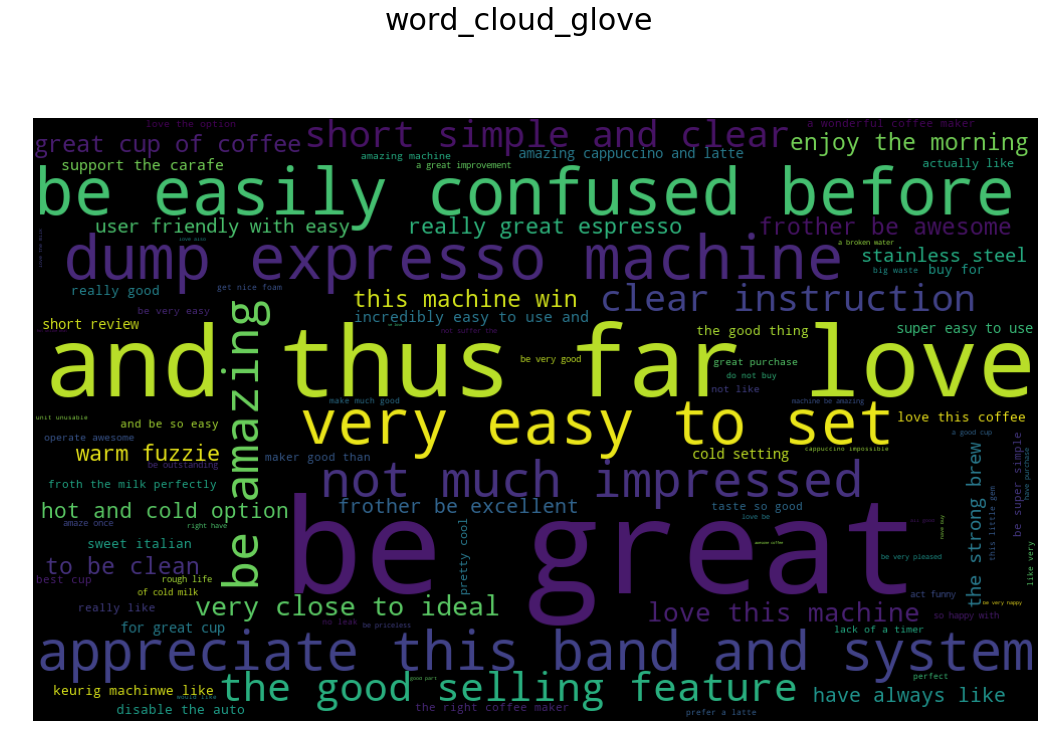

In [10]:
##======================  clustering result and make visualization  =======================##

def generate_wc(fname, df):
    #prepare for visualization
    frequency = df.set_index('phrases', drop = True).to_dict()['total_count']
    
    # Generate a word cloud image
    picture  =WordCloud(width=1000, height=600, margin=2)
    wordcloud = picture.generate_from_frequencies(frequency)
    plt.figure(figsize=(18, 12))
    plt.imshow(wordcloud, interpolation="kaiser")
    plt.axis("off")
    #plt.savefig("results/product_5_wordcloud.png")
    plt.suptitle(fname, fontsize=30)
    plt.show()

def make_clusters(km, opinion_phrases):
    clusters_w2v_km = km.fit_predict(similarity_matrix_w2v)
    clusters = pd.DataFrame(clusters_w2v_km, columns=['clusters'])
    phrases_new = pd.concat([opinion_phrases, clusters], axis=1)
    temp = phrases_new.groupby('clusters')['count'].sum()
    temp = temp.to_frame(name='total_count')
    temp = temp.reset_index(drop = False)

    final_result = phrases_new.drop_duplicates(subset='clusters', keep='first', inplace=False)
    final_result = final_result.reset_index(drop=True)
    final_result = final_result.merge(temp)
    return final_result

km = cluster.KMeans(n_clusters=100, precompute_distances=True)
final_result = make_clusters(km, opinion_phrases)
generate_wc('word_cloud_glove',final_result[['phrases', 'total_count']])

In [11]:
# final_result.to_csv('results/result_product_5.csv')
final_result

,phrases,count,length,clusters,total_count
0,be great,11,8,1,37
1,be amazing,5,10,61,22
2,love this machine,5,17,19,20
3,great cup of coffee,5,19,51,20
4,love this coffee,3,16,74,12
...,...,...,...,...,...
95,frother be awesome,1,18,34,19
96,very close to ideal,1,19,13,21
97,support the carafe,1,18,85,15
98,enjoy the morning,1,17,5,19


# 4. Result analysis and Hypothesis Test
- Get accuracies from different mmodels and run a hypothesis to see if there is any difference.
- From the final_result we obtained above, we can find for product 5, out 100, phrases of number "3, 11, 42, 63, 64, 70, 71, 77, 82, 87, 96, ", i.e."a long time, or cold, really like the, boost be call, etc." are not semantically revelent to the product. Which means the accuracy is . Also we can get all the accuracies for two models and all nine products.
- Paired/dependent T test are used for the nine data points here.
- The dataframe are accuracies we obtained

### 4.1 Check Assumptions
- 1.Outliers: from the boxplot, we can find there is no outliers.
- 2.Normal Distribution: From the QQ-PLOT, we can find the difference follows the normal distribution.

### 4.2 Hypostheis test and Power analysis
- Total there will be nine pairs of data point, after power analysis, when the effect size is 1.4, and significance level of 0.05, we can be 80% claim our experiments are reliable. 
- The null hypothesis is that there is no difference between accuracies between the two methods, while the alternative hypothesis is there is some difference. Statics of paired sample t test will be utilized here. After assumption check and hypothesis test, we got the p-value of 0.936, which is much larger than 0.05, the significance level, so that we do not reject null hypothesis and conclude that there is no significant difference between the accuracies between clustering models based on word2vec and glove embeddings.

- code citation:https://pythonfordatascience.org/paired-samples-t-test-python/

In [12]:
from statsmodels.stats.power import TTestIndPower
from scipy import  stats

#accuracies from two models
d = {'accuracy_w2v': [0.92, 0.91,0.87,0.85,0.9,0.89,0.8,0.91,0.91], 
     'accuracy_glove': [0.91, 0.9, 0.91,0.87,0.88,0.91,0.87,0.86,0.86]
    }

df = pd.DataFrame(data=d)
df.describe()

,accuracy_w2v,accuracy_glove
count,9.000000,9.000000
mean,0.884444,0.885556
std,0.038766,0.021858
min,0.800000,0.860000
25%,0.870000,0.870000
50%,0.900000,0.880000
75%,0.910000,0.910000
max,0.920000,0.910000


### 4.1 Check Assumptions
- 1.Outliers: from the boxplot, we can find there is no outliers.
- 2.Normal Distribution: From the QQ-PLOT, we can find the difference follows the normal distribution.

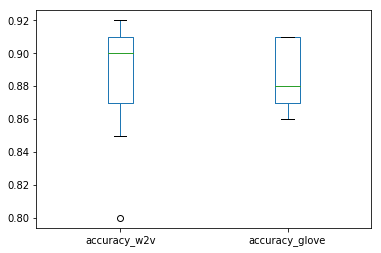

In [13]:
##========================== check 1. Outliers =============================##
df.plot(kind='box')
# This saves the plot as a png file
plt.savefig('boxplot_outliers.png')

(0.9491523504257202, 0.6807571649551392)

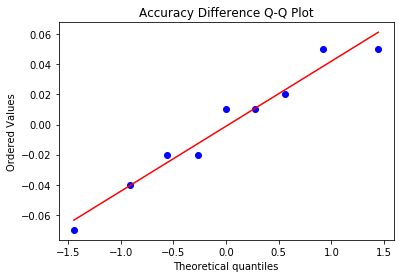

In [14]:
##========================== check 2. Normal Distributions =============================##
df['acc_difference'] = df['accuracy_w2v'] - df['accuracy_glove']
stats.probplot(df['acc_difference'], plot= plt)
plt.title('Accuracy Difference Q-Q Plot')
plt.savefig('Accuracy difference qq plot.png')

stats.shapiro(df['acc_difference'])
#The first value is the W test value, and the second value it the p-value. 
#We can find the test is non-significant(p_value=0.68)


### 4.2 Hypostheis test and Power analysis
- Total there will be nine pairs of data point, after power analysis, when the effect size is 1.41, and significance level of 0.05, we can be 80% claim our experiments are reliable. 
- The null hypothesis is that there is no difference between accuracies between the two methods, while the alternative hypothesis is there is some difference. Statics of paired sample t test will be utilized here. After assumption check and hypothesis test, we got the p-value of 0.936, which is much larger than 0.05, the significance level, so that we do not reject null hypothesis and conclude that there is no significant difference between the accuracies between clustering models based on word2vec and glove embeddings.


In [15]:
##========================== Hypothesis Test  =============================##
stats.ttest_rel(df['accuracy_w2v'], df['accuracy_glove'])
# WE find pvalue is very big, means we cannot reject H0. 
# So we can not claim there is difference between two accuracies.


Ttest_relResult(statistic=-0.08304547985373911, pvalue=0.9358557229417481)

In [16]:
# parameters for power analysis
effect = 1.41
alpha = 0.05
power = 0.8
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 8.966


# 5. Summary and Future work
### 5.1 Summary
In this work, we build a pipeline to extract opinions and cluster them when given a brunch of ecommerce reviews. For semanticly distance calculation and clustering, we tried word embedding models, Glove and word2vec. There is no significant semantic difference(effect size is 1.41, and significance level of 0.05, we can be 80% claim our experiments are reliable) between this two methods in this problem.

### 5.2 Future Work
The purpose of this work is offering online shoppers a tool to automatically extract and cluster opinions from massive numbers of product reviews. Figure 4 is a presentation of what we get using the 14350 rows of reviews records. With this, the shoppers can easily find some hot opinions (like “hot water”, “great price” ) and then improve the product. This visualization is an acceptable format for the shoppers.

# Author
Joshua Jin
https://github.com/jinwangjoshua

# Mentor
Professor Brown

# License
This project is free to use according to the MIT License as long as you cite me and the License (read the License for more details). You can cite this work by pointing to the following link: https://github.com/jinwangjoshua/Opinio-Extraction

Last update December 13, 2018